## Natural Language Processing

Group 4: Kiet Ly, Mary Monroe, and Shaswati Mukherjee

### Outline
* Summary
* Loading Data 
* Linguistic Features 
* Emotion Based Features
* Sentiment Based Features
* Topic Model Based Features
* Feature Selection


### Summary of Analysis and Features

This section describes the Natural Language Processing techniques used to create additional features for the Tweets data. In particular, 18 NLP features were generated based on sentiment analysis, emotional analysis and topic modelling techniques. Of those 18, a total of 9 were identified for inclusion in the models:

* sentiment_negative
* sentiment_neutral
* sentiment_positive
* token_count
* ant
* fear
* joy
* trust
* ratio_neg

#### Linguistic Features 
The **lexical diversity** score indicates how many different words are used within a body of text. The lexical diversity consists of the set of unique words in a tweet divided by the total number of tweets. The **token_count** and **url_token_ratio** are numeric fields that count how many tokens are in a tweet and have the ratio for urls to tokens per tweet. These field are used to characterize how long the tweet is and also indicate the composition of the tweet in terms of words vs links to media (other websites, images, music, etc). The idea behind this feature was thinking that bots would be built to promote other media, not original ideas.



#### Emotion Based Features
The **ant**, **disgust**, **fear**, **joy**, **sadness**, **surprise**, and **trust** features are boolean fields that indicate whether these emotions are  related to a given tweet. These assessments are created by comparing tweet tokens (words) with the EmoLex, the National Research Council (NRC) of Canada's Word-Emotion Association Lexicon. The EmoLex contains a mapping of words to emotions. If words within tweets have associated emotions within EmoLex, this would flag a 1 for the respective emotion feature.


#### Sentiment Based Features
The **sentiment_neutral**, **sentiment_positive**, and **sentiment_negative** features are boolean fields that indicate the sentiment predicted for a given tweet. These predictions were computed using built-in methods of the textblob module, an nltk wrapper. In particular the sentiment polarity method predicts sentiment based on a Bayesian model trained on a labeled corpus of movie reviews. We also computed the ratios for each sentiment seen across each user's body of tweets. These features were called **ratio_pos**, **ratio_neg** and **ratio_neu**.



#### Topic Model Based Features
The **jaccard** feature consists of a rough jaccard similarity score that compares a user's top 10 topics with the top 10 topics generated from a sample of bots. The topics were derived using Non-negative Matrix Factorization to highlight the most important topics from the user's corpus of tweets. These were applied as an enrichment to the individual tweet. The **perc_in_bot_topic** feature indicates the ratio of words from an individual tweet that were also found in the top 10 bot topics to the total number of words within the tweet.



### Loading Data

To begin this analysis, we loaded the modules and tweet data. NLP modules and functions used in this section came from langdetect, nltk, textblob and sklearn. 

In [2]:
import pandas as pd
import numpy as np
import langdetect
#either pip install langdetect or conda install -c conda-forge langdetect
from langdetect import detect
from pandas.plotting import scatter_matrix
import re
#conda install -c conda-forge textblob 
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
import html
from html.parser import HTMLParser
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
import textblob
from textblob import TextBlob
import string
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
pd.options.mode.chained_assignment = None 
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer;
from sklearn.decomposition import NMF;
from sklearn.preprocessing import normalize;
import pickle;
from time import time

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

Below are functions created to clean text data for NLP. Our analysis focused on English language lexicons and models built on English language data, so in addition to lemmatizing the words, and removing stopwords, punctuation, urls and url encoding, we detected language and filtered out non-english words

In [3]:
#Functions
class MLStripper(HTMLParser):
    #https://docs.python.org/3/library/html.parser.html
    #https://stackoverflow.com/questions/11061058/using-htmlparser-in-python-3-2
    def __init__(self):
        super().__init__()
        self.reset()
        self.fed = []
       
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ''.join(self.fed)

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

def remove_swords(text):
    #https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
    stop_words = set(stopwords.words('english'))   
    word_tokens = word_tokenize(text)  
    filtered_sentence = [w for w in word_tokens if not w in stop_words]   
    return filtered_sentence

def get_tweet_sentiment(tweet): 
        ''' 
        https://medium.freecodecamp.org/basic-data-analysis-on-twitter-with-python-251c2a85062e 
        Utility function to classify sentiment of passed tweet 
        using textblob's sentiment method 
        '''
        # create TextBlob object of passed tweet text 
        analysis = TextBlob(tweet) 
        # set sentiment 
        if analysis.sentiment.polarity > 0: 
            return 'positive'
        elif analysis.sentiment.polarity == 0: 
            return 'neutral'
        else: 
            return 'negative'

def lemmatize(text):
    #https://towardsdatascience.com/topic-modelling-in-python-with-nltk-and-gensim-4ef03213cd21
    text_out = []
    def get_lemma(word):
        lemma = wn.morphy(word)
        if lemma is None:
            return word
        else:
            return lemma
    
    for word in text:
        lword = get_lemma(word)
        text_out.append(lword)
    return text_out

def strip_unprintable(text):
    #https://stackoverflow.com/questions/8689795/how-can-i-remove-non-ascii-characters-but-leave-periods-and-spaces-using-python
    printable = set(string.printable)
    printable = filter(lambda x: x in printable, text)


def nlp_clean(text):
    #get rid of #retweets RT @[\S]+  mentions @[\S]+ urls http:\S+|https\S+|www.\S+ punctuation
    text_out = []
    result = ''
    try:
        result = re.sub(r"RT @[\S]+: |@[\S]+|http:\S+|https\S+|www.\S+|[^\w\s]", "", text) 
        
         #to lower case
        result = result.lower()
        
        #get rid of url encoding
        #https://stackoverflow.com/questions/11061058/using-htmlparser-in-python-3-2
        result = strip_tags(result)

        #get rid of special ascii characters
        result = ''.join([c for c in result if ord(c) < 128])

       
        #get rid of stopwords
        result = remove_swords(result)

        #get word roots
        result = lemmatize(result)
        
    except:
        text_out = ['Failed']
    
    return result

def nlp_clean_flag(text, returnlist = False):
    #get rid of #retweets RT @[\S]+  mentions @[\S]+ urls http:\S+|https\S+|www.\S+ punctuation
    text_out = []
    result = ''
    try:
        result = re.sub(r"RT @[\S]+: |@[\S]+|http:\S+|https\S+|www.\S+|[^\w\s]", "", text) 
        
         #to lower case
        result = result.lower()
        
        #result = strip_unprintable(result)
        
        #get rid of url encoding
        #https://stackoverflow.com/questions/11061058/using-htmlparser-in-python-3-2
        result = strip_tags(result)

        #get rid of special ascii characters
        result = ''.join([c for c in result if ord(c) < 128])

       
        #get rid of stopwords
        result = remove_swords(result)
        
        #get word roots
        result = lemmatize(result)
        
        if returnlist == False:
            result = " ".join(str(x) for x in result)
               
    except:
        text_out = ['Failed']
    
    return result

def df_detect_en(df, text_col):
    
    '''Input is a dataframe (df) and name of the column (text_col) to check for english 
    This function creates a new Boolean column called "en_flag"
    "en_flag" is True if the text_col column is detected as "en" 
    Dataframe with the new column is returned.
    '''
    
    def detect_en(x):
        #assumes you have langdetect imported
        flag = False
        if len(x) > 0:
            try:
                lang = detect(x)
                if lang=='en':
                    flag = 1
            except:
                flag = 0
                
                
            return flag
    
    df[text_col] = df[text_col].astype(str)
    df['en_flag'] = df.loc[:,text_col].apply(lambda x: detect_en(x))
    return(df)


def clean_tweets(df, text_col):
    #creates two new features
    #word_bag is our bag of words that has been cleaned
    #sentiment is the sentiment for the individual tweet
    df['word_bag'] = df[text_col].apply(lambda x: nlp_clean(x))
    
    return(df) 


Here we read in all the data and clean the text for NLP.

In [4]:
#read in all the tweets from geniuine accounts
human_tweets = pd.read_csv('~/Documents/GitHub/cs109a/data/human_tweets_100.csv',index_col=None, header=0,keep_default_na=False)
bot_tweets = pd.read_csv('~/Documents/GitHub/cs109a/data/bot_tweets_100.csv', index_col=None, header=0,keep_default_na=False)
sbot_tweets = pd.read_csv('~/Documents/GitHub/cs109a/data/social_tweets_100.csv', index_col=None, header=0,keep_default_na=False)
human_tweets = human_tweets.drop(["Unnamed: 0", "Unnamed: 0.1"], axis=1)
bot_tweets = bot_tweets.drop(["Unnamed: 0", "Unnamed: 0.1"], axis=1)
sbot_tweets = sbot_tweets.drop(["Unnamed: 0", "Unnamed: 0.1"], axis=1)
#We will combine these two data sets then get a sample to analyze
tweets_some = pd.concat([human_tweets, bot_tweets], sort=False)
tweets_all = pd.concat([tweets_some, sbot_tweets], sort=False)
tweets_all = tweets_all[pd.notna(tweets_all['text'])]
tweets_all['clean_text'] = tweets_all.loc[:,'text'].apply(lambda x: nlp_clean_flag(x, returnlist=False))

### Create Linguistic Features


Next we create the *token_count* and *url_token_ratio* features.

In [58]:
#compute new features: token count and url to token ratio
tweets_all['token_count'] = tweets_all.loc[:,'text'].apply(lambda x: len(x))

tweets_all['url_token_ratio'] = tweets_all['num_urls']/tweets_all['token_count']

### Emotional Analysis Features

To label tweets with emotion, we compared the tweet text with emoLex, the lexicon built by the NRC that maps words to their emotion. Here we build the dataframe.

In [17]:
#make our dictionary for emotional 
#http://sentiment.nrc.ca/lexicons-for-research/

emo = pd.read_csv('~/Documents/GitHub/cs109a_work/eda/NRC-Emotion-Lexicon/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt',\
                  names = ['word','emotion','flag'], sep="\t")
emo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141820 entries, 0 to 141819
Data columns (total 3 columns):
word       141810 non-null object
emotion    141820 non-null object
flag       141820 non-null int64
dtypes: int64(1), object(2)
memory usage: 3.2+ MB


In [18]:
emo = emo.loc[emo['flag']==1]
emo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13901 entries, 19 to 141755
Data columns (total 3 columns):
word       13901 non-null object
emotion    13901 non-null object
flag       13901 non-null int64
dtypes: int64(1), object(2)
memory usage: 434.4+ KB


In [19]:
#break up words into their emotions
#anticipation','disgust','fear','joy','negative','positive','sadness','surprise','trust'

ant = list(emo.loc[emo['emotion']=='anticipation'].word)
disgust = list(emo.loc[emo['emotion']=='disgust'].word)
fear = list(emo.loc[emo['emotion']=='fear'].word)
joy = list(emo.loc[emo['emotion']=='joy'].word)
sadness = list(emo.loc[emo['emotion']=='sadness'].word)
surprise = list(emo.loc[emo['emotion']=='surprise'].word)
trust = list(emo.loc[emo['emotion']=='trust'].word)
feelings = {'ant':ant, 'disgust':disgust , 'fear':fear, 'joy':joy, 'sadness':sadness, 'surprise':surprise, 'trust':trust}

In [20]:
def checkemo(x, emotions_list):
    words = re.sub("[^\w]", " ",  x).split()
    flag = 0
    matches = set(words) & set(emotions_list)
    if len(matches) > 0:
        flag = 1
    return(flag)

In [21]:
#Emotional Analysis --> creates anticipation, disgust, fear, joy, sadness, surprise, trust
for key,values in feelings.items():
    tweets_all[key] = tweets_all.loc[:,'text'].apply(lambda x: checkemo(x,values))

### Sentiment Analysis

In [22]:
#get sentiment
def sentiment(text):
    sentiment = get_tweet_sentiment(text)
    return sentiment 

def compute_sentiment_percentages(df, text_col, user_id_col):
    #measure sentiment, then create dummy variables    
    df['sentiment'] = df[text_col].astype(str).apply(lambda x: sentiment(x))
    df = pd.get_dummies(df, columns=['sentiment'])
    return df

In [23]:
#Sentiment Analysis --> creates positive/negative/neutral sentiment
tweets_all = compute_sentiment_percentages(tweets_all, 'text','user_id')

In [24]:
tweets_grouped2 = tweets_all.groupby('user_id')['sentiment_negative','sentiment_positive','sentiment_neutral'].sum()
tweets_grouped2 = tweets_grouped2.reset_index()
tweets_grouped2['sent_sum'] = tweets_grouped2['sentiment_negative'] + tweets_grouped2['sentiment_positive'] + tweets_grouped2['sentiment_neutral']
tweets_grouped2['ratio_pos'] = tweets_grouped2['sentiment_positive']/tweets_grouped2['sent_sum']
tweets_grouped2['ratio_neg'] = tweets_grouped2['sentiment_negative']/tweets_grouped2['sent_sum']
tweets_grouped2['ratio_neu'] = tweets_grouped2['sentiment_neutral']/tweets_grouped2['sent_sum']
tweets_grouped2 = tweets_grouped2.drop(['sentiment_negative','sentiment_positive','sentiment_neutral', 'sent_sum'], axis=1)
tweets_all = pd.merge(tweets_all, tweets_grouped2, on='user_id')

### Topic Modeling

To compute our two topic-model based features, we first compute the top 10 topics from a sample of bots. We used Non-negative Matrix Factorization (NMF) as an unsupervised way to identify the major topics from which a body of a users tweets is composed. The function below uses tf-idf to further filter stop words, common words (seen in 95% or more of the tweets), or highly unique (seen in only 1 text).

In [25]:
def get10topics(x):
# Function adapted from sklearn tutorial code
# originally written by
# Author: Olivier Grisel <olivier.grisel@ensta.org>
#         Lars Buitinck
#         Chyi-Kwei Yau <chyikwei.yau@gmail.com>
# License: BSD 3 clause
    n_samples = len(x)
    n_features = 1000
    n_components = 10
    n_top_words = 20
    top_word_list = []
    
       
    def get_top_words(model, feature_names, n_top_words):
        top_word_list = []
        
        for topic_idx, topic in enumerate(model.components_):
            message = ''
            message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
            
            top_word_list.append(message)
        
        return top_word_list

# Load the tweets and vectorize. Use Term Frequency-Inverse Document Frequency
# To further filter out common words. This syntax removes english stop words
# and words occurring in only one document or at least 95% of the documents.
   
    error_cnt=0
    try:
        data_samples = x
        
        tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                           max_features=n_features,
                                           stop_words='english')
        tfidf = tfidf_vectorizer.fit_transform(data_samples)


        # Fit the NMF model
      
        nmf = NMF(n_components=n_components, random_state=1, alpha=.1, l1_ratio=.5).fit(tfidf)
    
        #print("\nTopics in NMF model (Frobenius norm):")
        tfidf_feature_names = tfidf_vectorizer.get_feature_names()
        
        top_word_list=get_top_words(nmf, tfidf_feature_names, n_top_words)
    except:
        top_word_list = []
    
    return top_word_list

Here, we filter the data for a sample of bot data, topic model each individual bot user, then combine all these topics together to create a final top 10 for all the bots

In [26]:
tweets_bots = tweets_all.loc[tweets_all['user_type'] == 0]
tweets_bots = resample(tweets_bots, n_samples=30000, replace=False)
#Only keep english language tweets
tweets_bots = df_detect_en(tweets_bots,'text')
tweets_bots = tweets_bots.loc[tweets_bots['en_flag']==1]
t0 = time()

#Compute topics per bot user
tweets_bots = tweets_bots.groupby('user_id').agg(lambda x: x.tolist())
tweets_bots = tweets_bots.reset_index()
tweets_bots['topics'] = tweets_bots.loc[:,'clean_text'].apply(lambda x: get10topics(x))

#filter out users with 0 topics
tweets_bots['topic_len'] = tweets_bots.loc[:,'topics'].apply(lambda x: len(x))
tweets_bots= tweets_bots.loc[tweets_bots['topic_len'] > 0]
tweets_bots['dummy'] = 1
tweets_bots_grp = tweets_bots.groupby('dummy').agg(lambda x: x.tolist())

#Create Top 10 topic models from all the social spambot users
tweets_bots_grp = tweets_bots_grp.reset_index()
tweets_bots_final = get10topics(list(tweets_bots_grp['clean_text'])[0][0])

#### Percent of a tweet's word also found in bot topics

Next, we compared each individual tweet against the bot topics. We created a score that gives the ratio for words from the tweet also seen in bot topics divided by the total number of words in the tweet. This value is indicated in the **'perc_in_bot_topics'**.

In [27]:
def percent_tweet_in_bot_topics(clean_text,bots_topics):
    #https://towardsdatascience.com/overview-of-text-similarity-metrics-3397c4601f50
    bot_string = ''
    for topic in bots_topics:
        bot_string = bot_string + topic + " "
    a = set(str(clean_text).split()) 
    b = set(bot_string.split())
    try:
        len_clean_text = len(a)
        score = a.intersection(b)
        percent_in_tweet = total/len_clean_text  
    except:
        percent_in_tweet = 0
    return percent_in_tweet    

In [28]:
t0 = time()
tweets_all['perc_in_bot_topic'] = tweets_all.loc[:,'clean_text'].apply(lambda x: percent_tweet_in_bot_topics(x, tweets_bots_final))
print("done in %0.3fs." % (time() - t0))

done in 3.348s.


Unfortunately, this metric returned 0 for every record. Because the individual tweets are so short, we suspect that comparing the individual tweet's tokens with the bot topics is not a good metric.

#### Jaccard score

To compute the similarity between an individual user's top 10 topics with the bot topics, we computed a Jaccard Score. Recall that we calculated the top 10 bot topics, so in the next few cells we compute the top 10 topic models for each user. 

In [35]:
t0 = time()
tweets_grouped = tweets_all.groupby('user_id').agg(lambda x: x.tolist())
tweets_grouped = tweets_grouped.reset_index()
tweets_grouped['topics'] = tweets_grouped.loc[:,'clean_text'].apply(lambda x: get10topics(x)) 
print("done in %0.3fs." % (time() - t0))

done in 12.506s.


Next we computed the Jaccard score, which indicates how much the user and bot's topics overlap, then merged this data back in with the tweets data.

In [36]:
def jaccard(x,bots_topics):
    #https://towardsdatascience.com/overview-of-text-similarity-metrics-3397c4601f50    
    def get_jaccard_sim(str1, str2): 
        
        a = set(str1.split()) 
        b = set(str2.split())
        
        c = a.intersection(b)
        return float(len(c)) / (len(a) + len(b) - len(c))
    total = 0
    a=''
    b=''
    for a in x:
        for b in bots_topics:
            score = get_jaccard_sim(a,b)
        total += score
    return total/10    

In [41]:
tweets_grouped['jaccard'] = tweets_grouped.loc[:,'topics'].apply(lambda x: jaccard(x, tweets_bots_final))
tweets_grouped_final = tweets_grouped[['user_id','jaccard']]
tweets_final = pd.merge(tweets_all, tweets_grouped_final, on='user_id')
tweetchunk = np.array_split(tweets_final, 3)
tweetchunk[0].to_csv('tweets_nlp_1_final.csv')
tweetchunk[1].to_csv('tweets_nlp_2_final.csv')
tweetchunk[2].to_csv('tweets_nlp_3_final.csv')

### Feature Selection

In [5]:
#tweets1 = pd.read_csv('tweets_nlp_1_2.csv')
#tweets2 = pd.read_csv('tweets_nlp_2_2.csv')
#tweets3 = pd.read_csv('tweets_nlp_3_2.csv')
#tweets_final = pd.concat([tweets1, tweets2, tweets3], sort=False)

def variance_threshold_selector(data, threshold=0.5):
    #https://stackoverflow.com/questions/39812885/retain-feature-names-after-scikit-feature-selection
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

tweets_final.replace([np.inf, -np.inf], np.nan, inplace=True)
tweets_final.fillna(value=0, axis=1, inplace=True)

tweets_all_var = tweets_final[['retweet_count', 'favorite_count', 'num_hashtags', 'num_urls', 'num_mentions',\
                                 'user_type', 'sentiment_negative', 'sentiment_neutral', 'sentiment_positive',\
                                 'ratio_pos', 'ratio_neg', 'ratio_neu', 'token_count','url_token_ratio', \
                                 'ant','disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust', 'jaccard']]
blah = variance_threshold_selector(tweets_all_var, threshold=(.95*.1)).columns
for thing in blah:
    print(thing)

retweet_count
favorite_count
num_hashtags
num_urls
num_mentions
user_type
sentiment_negative
sentiment_neutral
sentiment_positive
token_count
ant
fear
joy
trust


Let's analyze the ratios before we discard them. A scatter matrix plots indicates that a linear correlation exists between ratio_neu and ratio_neg. We will keep ratio_neg because it does not appear to be correlated.

Scatter Matrix for Sentiment Ratio Values


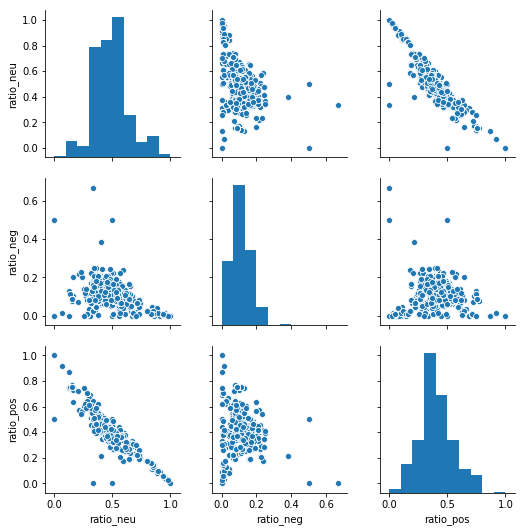

In [8]:
import seaborn as sns;
tweets_ratios = tweets_all_var[['ratio_neu', 'ratio_neg', 'ratio_pos']]
t_final_sample = resample(tweets_ratios, n_samples=5000, replace=False)
g = sns.pairplot(t_final_sample)
print('Scatter Matrix for Sentiment Ratio Values')

### Resources

https://www.youtube.com/watch?v=UQGEB3Q5-fQ https://medium.com/ml2vec/topic-modeling-is-an-unsupervised-learning-approach-to-clustering-documents-to-discover-topics-fdfbf30e27df
http://hebb.mit.edu/people/seung/pape... http://www.cs.helsinki.fi/u/phoyer/pa... http://hebb.mit.edu/people/seung/pape...
watch this later: https://www.youtube.com/watch?v=ZTxXGZwe2gw
https://arxiv.org/pdf/1308.6297.pdf

https://www.geeksforgeeks.org/twitter-sentiment-analysis-using-python/

https://codereview.stackexchange.com/questions/181152/identify-and-extract-urls-from-text-corpus

https://en.wikipedia.org/wiki/Naive_Bayes_classifier

https://streamhacker.com/2010/05/10/text-classification-sentiment-analysis-naive-bayes-classifier/

https://nlpforhackers.io/topic-modeling/

https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24

https://towardsdatascience.com/topic-modelling-in-python-with-nltk-and-gensim-4ef03213cd21

https://towardsdatascience.com/sentiment-analysis-with-python-part-1-5ce197074184

http://www.nltk.org/book/ch06.html

https://medium.freecodecamp.org/basic-data-analysis-on-twitter-with-python-251c2a85062e 
